# 기계학습 과제(2)

# Default of Credit Card Clients data set

We will create Decision tree models in order to make predictions and compare them with the original paper.  
   
=> After the initial predictions, model will be "optimized" by GridSearchCV estimator (search for the best set of hyperparameters for every model)

- Goal
: Using the models we created, we will try to predict the class value of dpnm column with better scores (accuracy and f1) than the scores presented in the original paper.

In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import graphviz # 다이어그램을 파이썬 코드로 작업할 수 있게 만들어주는 라이브러리 : graphviz
from graphviz import Source
from IPython.display import SVG

# ML Models
from sklearn import tree
from sklearn.tree import BaseDecisionTree
from sklearn.tree import export_text
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

# Metrics
from sklearn import metrics
from sklearn.metrics import f1_score,confusion_matrix, mean_squared_error, mean_absolute_error, classification_report, roc_auc_score, roc_curve, precision_score, recall_score

## Part 1: Load and clean the data
- Load the data from the csv file and check for any "impurities", such as null values or duplicate rows. 
- If any of these will appear, we will remove them from the data set. 
- We will also plot the correlations of the class column with all the other columns.

In [2]:
# Load the data.
data = pd.read_csv('default of credit card clients.csv')
data

ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  \
0          1      20000    2          2         1   24      2      2     -1   
1          2     120000    2          2         2   26     -1      2      0   
2          3      90000    2          2         2   34      0      0      0   
3          4      50000    2          2         1   37      0      0      0   
4          5      50000    1          2         1   57     -1      0     -1   
...      ...        ...  ...        ...       ...  ...    ...    ...    ...   
29995  29996     220000    1          3         1   39      0      0      0   
29996  29997     150000    1          3         2   43     -1     -1     -1   
29997  29998      30000    1          2         2   37      4      3      2   
29998  29999      80000    1          3         1   41      1     -1      0   
29999  30000      50000    1          2         1   46      0      0      0   

       PAY_4  ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  \
0         -1  ...          0          0          0         0       689   
1          0  ...       3272       3455       3261         0      1000   
2          0  ...      14331      14948      15549      1518      1500   
3          0  ...      28314      28959      29547      2000      2019   
4          0  ...      20940      19146      19131      2000     36681   
...      ...  ...        ...        ...        ...       ...       ...   
29995      0  ...      88004      31237      15980      8500     20000   
29996     -1  ...       8979       5190          0      1837      3526   
29997     -1  ...      20878      20582      19357         0         0   
29998      0  ...      52774      11855      48944     85900      3409   
29999      0  ...      36535      32428      15313      2078      1800   

       PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  default payment next month  
0             0         0         0         0                           1  
1          1000      1000         0      2000                           1  
2          1000      1000      1000      5000                           0  
3          1200      1100      1069      1000                           0  
4         10000      9000       689       679                           0  
...         ...       ...       ...       ...                         ...  
29995      5003      3047      5000      1000                           0  
29996      8998       129         0         0                           0  
29997     22000      4200      2000      3100                           1  
29998      1178      1926     52964      1804                           1  
29999      1430      1000      1000      1000                           1  

[30000 rows x 25 columns]

In [3]:
# Information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

- ID column이 인덱싱 목적뿐이기에 제거

In [4]:
# Drop "ID" column
data = data.drop(['ID'], axis=1)

- 중복 열 확인, 있다면 제거

In [5]:
# Check for duplicate rows
print(f"There are {data.duplicated().sum()} duplicated rows in the data set.")

# Remove duplicate rows.
data = data.drop_duplicates()
print("The duplicate rows are removed.")

There are 35 duplicated rows in the data set.
The duplicate rows are removed.


- null값 체크하기

In [6]:
# Check for null values
print(f"There are {data.isna().any().sum()} cells with null values in the data set.")

There are 0 cells with null values in the data set.


- 데이터셋의 상관관계 matrix plot

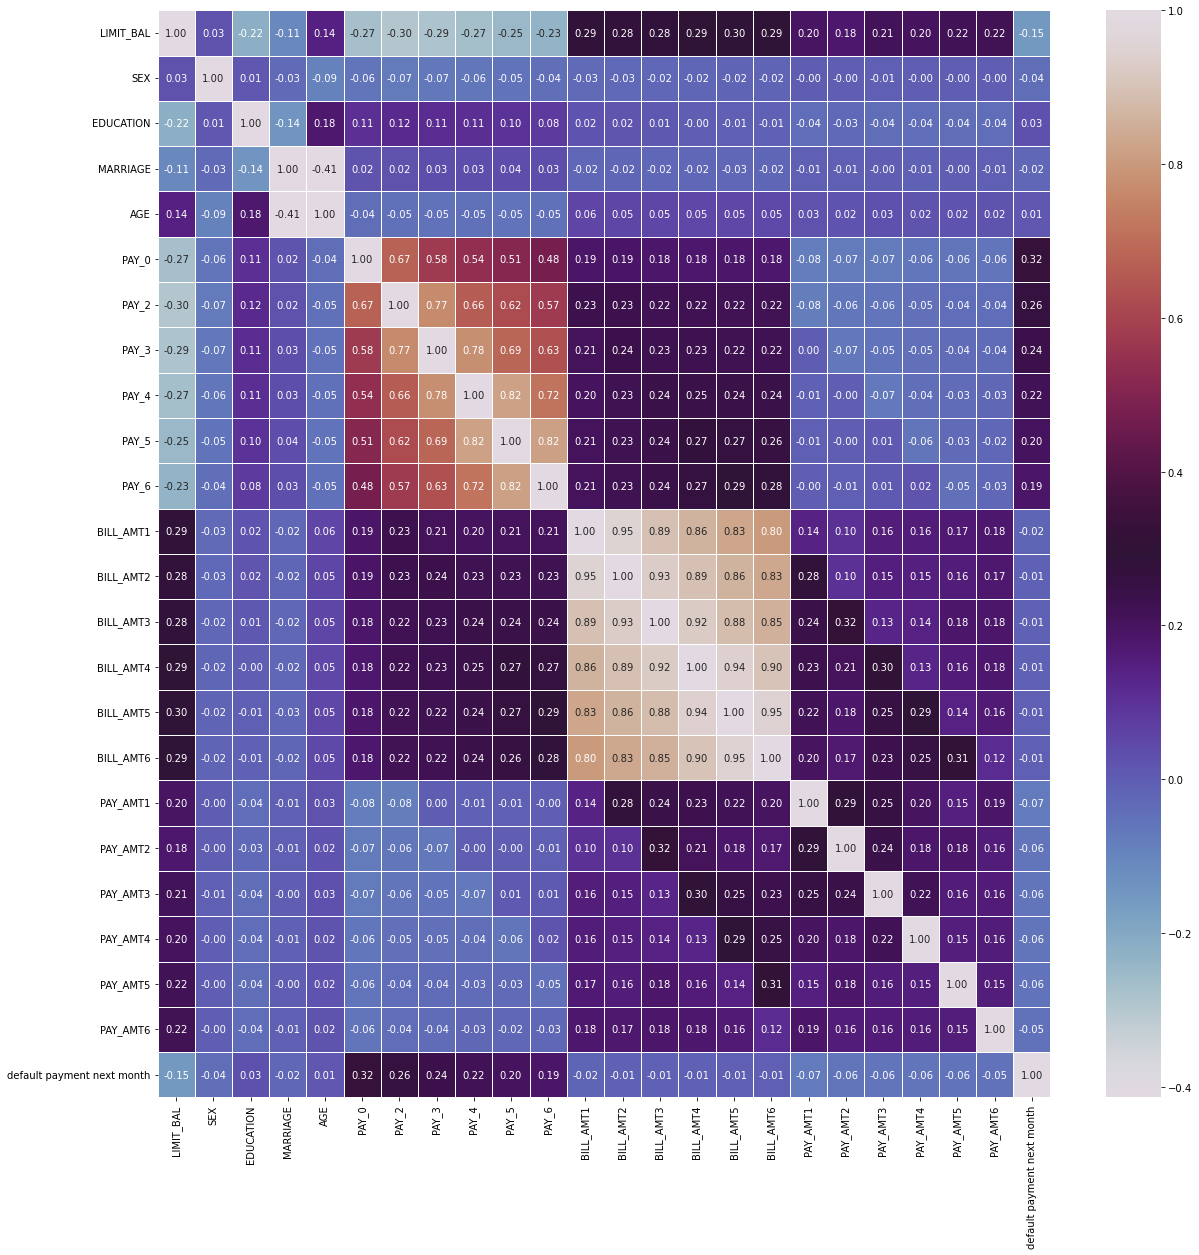

In [7]:
plt.figure(figsize = (20,20))
sns.heatmap(data.corr(), annot = True, cmap = 'twilight', linewidth = 0.5, fmt = '.2f');

## Part 2: Pre-processing
- Prepare data for models. 
- zchoose the columns that will be our independed variables and which column the class that we want to predict. 
- After that, split data into train and test sets and perfom a standardization upon them.

In [8]:
# Distinguish attribute columns and class column
X = data[data.columns[ : -1]]
y = data['default payment next month']

In [9]:
# Split to train and test sets. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 25)

In [10]:
# Standardization
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Part 3: Modeling
In this section, build models:

- Decision tree  

=> Model will be trained and make a prediction for the test set. 
- Accuracy, f1 score, confusion matrix and ROC will be calculated for each model. 
- Then we will use the GridSearchCV module to tune our models and search for the best hyperparameters (increase the accuracy of each model)

### Decision tree

In [11]:
# Initialize a decision tree estimator
tr = tree.DecisionTreeClassifier(max_depth = 3, criterion = 'gini', random_state = 25)

# Train the estimator
tr.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=25)

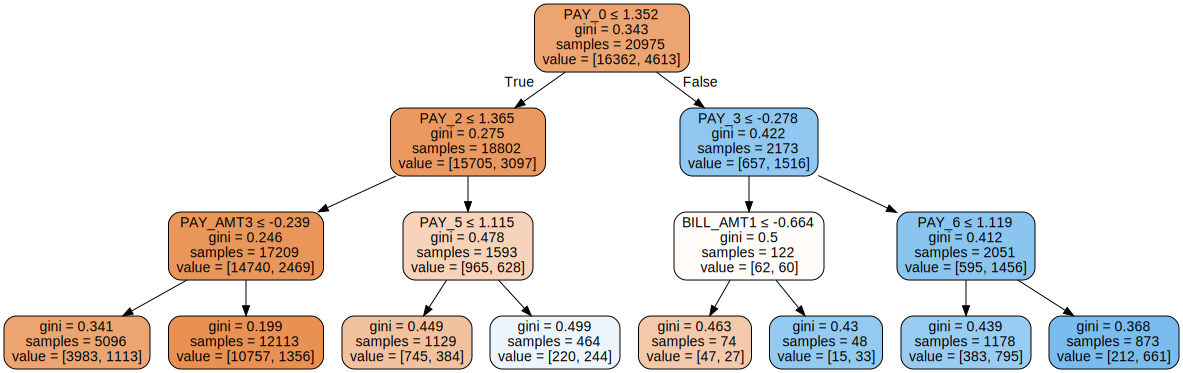

In [12]:
# Plot the tree.
dot_data = tree.export_graphviz(tr, out_file = None, feature_names = X.columns, 
                                filled = True, rounded = True, special_characters = True)  
graph = graphviz.Source(dot_data)  
graph

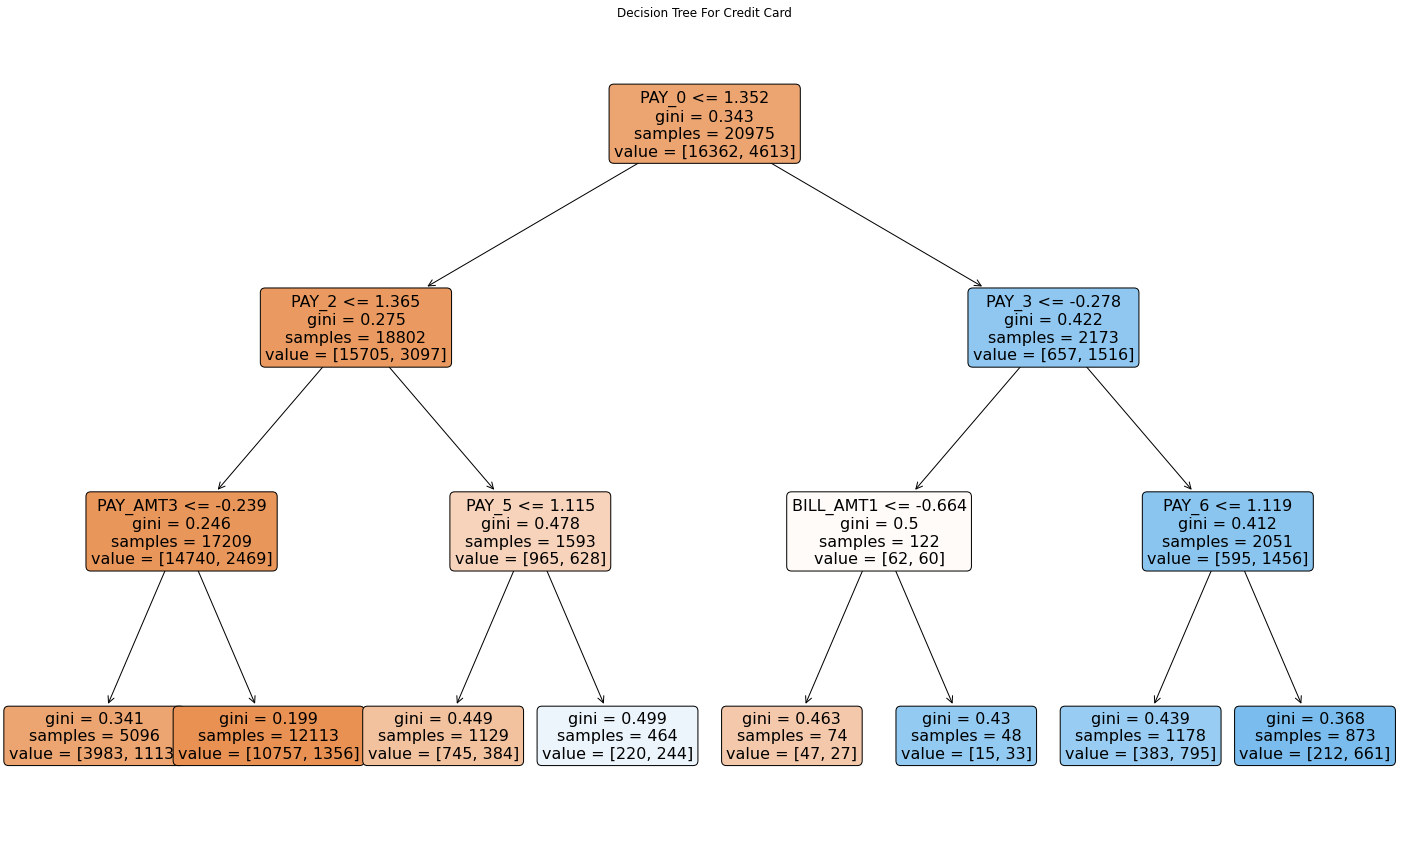

In [13]:
# Plot the tree
fig = plt.figure(figsize = (25, 15))
tree.plot_tree(tr.fit(X_train, y_train), feature_names = X.columns, filled = True, rounded = True, fontsize = 16);
plt.title('Decision Tree For Credit Card');

In [14]:
# simplified version
r = export_text(tr, feature_names = X.columns.tolist())
print(r)

|--- PAY_0 <= 1.35
|   |--- PAY_2 <= 1.36
|   |   |--- PAY_AMT3 <= -0.24
|   |   |   |--- class: 0
|   |   |--- PAY_AMT3 >  -0.24
|   |   |   |--- class: 0
|   |--- PAY_2 >  1.36
|   |   |--- PAY_5 <= 1.11
|   |   |   |--- class: 0
|   |   |--- PAY_5 >  1.11
|   |   |   |--- class: 1
|--- PAY_0 >  1.35
|   |--- PAY_3 <= -0.28
|   |   |--- BILL_AMT1 <= -0.66
|   |   |   |--- class: 0
|   |   |--- BILL_AMT1 >  -0.66
|   |   |   |--- class: 1
|   |--- PAY_3 >  -0.28
|   |   |--- PAY_6 <= 1.12
|   |   |   |--- class: 1
|   |   |--- PAY_6 >  1.12
|   |   |   |--- class: 1



In [15]:
# Make predictions
tr_pred = tr.predict(X_test)

# CV score
tr_cv = cross_val_score(tr, X_train, y_train, cv=10).mean()

### Metrics for Decision tree

In [16]:
# Accuracy: 1 is perfect prediction.
print('Accuracy: %.3f' % tr.score(X_test, y_test))

# Cross-Validation accuracy
print('Cross-validation accuracy: %0.3f' % tr_cv)

# Precision
print('Precision: %.3f' % precision_score(y_test, tr_pred))

# Recall
print('Recall: %.3f' % recall_score(y_test, tr_pred))

# f1 score: best value at 1 and worst at 0.
print('F1 score: %.3f' % f1_score(y_test, tr_pred))

Accuracy: 0.818
Cross-validation accuracy: 0.822
Precision: 0.671
Recall: 0.375
F1 score: 0.481


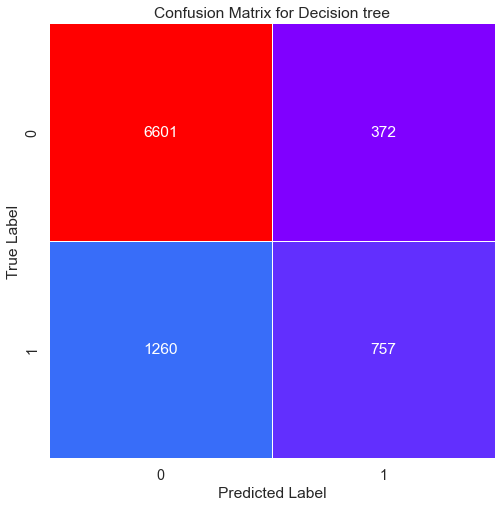

In [17]:
# Plot confusion matrix for Decision tree.
tr_matrix = confusion_matrix(y_test,tr_pred)
sns.set(font_scale = 1.3)
plt.subplots(figsize = (8, 8))
sns.heatmap(tr_matrix, annot = True, cbar = False, cmap = 'rainbow', linewidth = 0.5, fmt = "d")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for Decision tree');

In [18]:
# Predict propabilities for the test data.
tr_probs = tr.predict_proba(X_test)

# Keep Probabilities of the positive class only.
tr_probs = tr_probs[:, 1]

# AUC Score
auc_tr = roc_auc_score(y_test, tr_probs)
print('AUC: %.2f' % auc_tr)

AUC: 0.73


### Grid search for Decision tree

In [19]:
parameters = {'criterion':['gini','entropy'],
              'max_depth':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
             }

# MLP estimator
default_tr = tree.DecisionTreeClassifier(random_state = 25)

# GridSearchCV estimator
gs_tree = GridSearchCV(default_tr, parameters, cv = 10, n_jobs = -1, verbose = 1)

# Train the GridSearchCV estimator and search for the best parameters
gs_tree.fit(X_train, y_train)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=25),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20]},
             verbose=1)

In [20]:
# Make predictions with the best parameters.
gs_tree_pred = gs_tree.predict(X_test)

### Metrics for Grid Search Decision tree

In [21]:
# Best parameters.
print("Best Decision tree Parameters: {}".format(gs_tree.best_params_))

# Cross validation accuracy for the best parameters.
print('Cross-validation accuracy: %0.3f' % gs_tree.best_score_)

# Accuracy: 1 is perfect prediction.
print('Accuracy: %0.3f' % (gs_tree.score(X_test,y_test)))

# Precision
print('Precision: %.3f' % precision_score(y_test, gs_tree_pred))

# Recall
print('Recall: %.3f' % recall_score(y_test, gs_tree_pred))

# f1 score: best value at 1 (perfect precision and recall) and worst at 0.
print('F1 score: %.3f' % f1_score(y_test, gs_tree_pred))

Best Decision tree Parameters: {'criterion': 'entropy', 'max_depth': 4}
Cross-validation accuracy: 0.822
Accuracy: 0.817
Precision: 0.698
Recall: 0.326
F1 score: 0.445


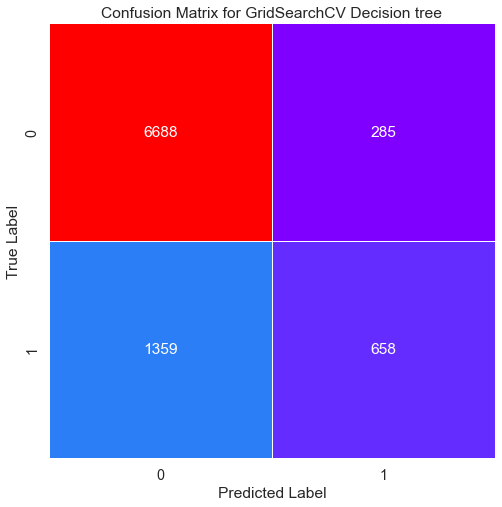

In [22]:
# Plot confusion matrix for Decision tree.
gs_tr_matrix = confusion_matrix(y_test,gs_tree_pred)
sns.set(font_scale = 1.3)
plt.subplots(figsize = (8, 8))
sns.heatmap(gs_tr_matrix, annot = True, cbar = False, cmap = 'rainbow', linewidth = 0.5, fmt = "d")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for GridSearchCV Decision tree');

In [23]:
# Predict probabilities for the test data.
gs_tree_probs = gs_tree.predict_proba(X_test)

# Keep Probabilities of the positive class only.
gs_tree_probs = gs_tree_probs[:, 1]

# AUC Score
gs_tree_auc = roc_auc_score(y_test, gs_tree_probs)
print('AUC: %.2f' % gs_tree_auc)

AUC: 0.75


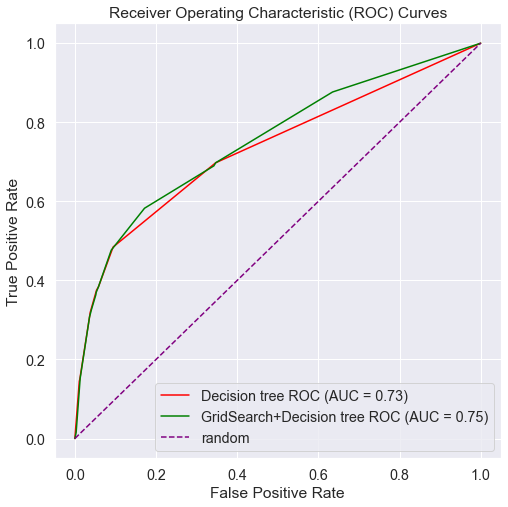

In [24]:
# Get the ROC Curves.
gs_tr_fpr, gs_tr_tpr, gs_tr_thresholds = roc_curve(y_test, gs_tree_probs)
tr_fpr, tr_tpr, tr_thresholds = roc_curve(y_test, tr_probs)

# Plot the ROC curves.
plt.figure(figsize=(8,8))
plt.plot(tr_fpr, tr_tpr, color = 'red', label = 'Decision tree ROC (AUC = %0.2f)'% auc_tr)
plt.plot(gs_tr_fpr, gs_tr_tpr, color = 'green', label = 'GridSearch+Decision tree ROC (AUC = %0.2f)'% gs_tree_auc)
plt.plot([0, 1], [0, 1], color = 'purple', linestyle = '--', label = 'random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend()
plt.show()

### Results

In [25]:
metrics=['Accuracy', 'CV accuracy', 'Precision','Recall','F1','ROC AUC']

fig = go.Figure(data = [go.Bar(name = 'Decision tree', x = metrics,
           y = [tr.score(X_test, y_test), tr_cv,precision_score(y_test, tr_pred),
              recall_score(y_test, tr_pred),f1_score(y_test, tr_pred),auc_tr])])
                
fig.update_layout(title_text = 'Metrics for each', barmode = 'group', xaxis_tickangle = -45, bargroupgap = 0.05)
fig.show()

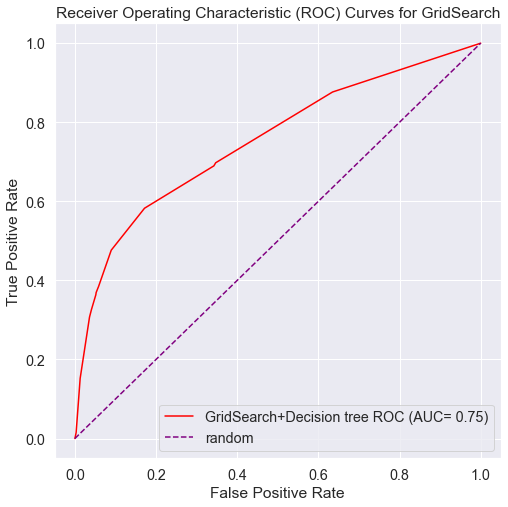

In [26]:
# Plot the ROC curve.
plt.figure(figsize=(8,8))
plt.plot(gs_tr_fpr, gs_tr_tpr, color = 'red', label = 'GridSearch+Decision tree ROC (AUC= %0.2f)'% gs_tree_auc)
plt.plot([0, 1], [0, 1], color = 'purple', linestyle = '--', label = 'random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves for GridSearch')
plt.legend()
plt.show()

In [27]:
d={
'': ['Decision Tree', 'GridSearchCV + Decision Tree',],
'Accuracy': [tr.score(X_test, y_test), gs_tree.score(X_test, y_test)],
'CV Accuracy': [tr_cv, gs_tree.best_score_],
'Precision': [precision_score(y_test, tr_pred), precision_score(y_test, gs_tree_pred)],
'Recall': [recall_score(y_test, tr_pred), recall_score(y_test, gs_tree_pred)],
'F1': [f1_score(y_test, tr_pred), f1_score(y_test, gs_tree_pred)],
'ROC AUC': [auc_tr, gs_tree_auc]
}

results = pd.DataFrame(data = d).round(3).set_index('')
results

Accuracy  CV Accuracy  Precision  Recall     F1  \
                                                                                
Decision Tree                    0.818        0.822      0.671   0.375  0.481   
GridSearchCV + Decision Tree     0.817        0.822      0.698   0.326  0.445   

                              ROC AUC  
                                       
Decision Tree                   0.733  
GridSearchCV + Decision Tree    0.752

## 추가 코드!!

### 1. 실험환경 구성

In [28]:
# 라이브러리 로드
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split # 학습, 테스트set 구분
from sklearn.tree import export_graphviz # tree 시각화를 위해

# export_graphviz : 의사결정나무에 대한 graphviz dot data 생성하는 함수
import graphviz # tree 시각화
import sklearn.metrics as mt # 성능지표를 계산하기 위해 import
from sklearn.model_selection import cross_val_score, cross_validate # 교차검증

import warnings
warnings.filterwarnings('ignore')

### 2. 교차검증 Cross Validation

In [29]:
dt_clf = DecisionTreeClassifier(random_state=5764)
dt_clf.fit(X_train, y_train) # 학습

# 각 폴드의 스코어 
scores = cross_val_score(dt_clf, X, y, cv = 5)

print('Averaged results of cross validation: ', scores.mean())

Averaged results of cross validation:  0.7238444852327716


In [30]:
pd.DataFrame(cross_validate(dt_clf, X, y, cv =5))

fit_time  score_time  test_score
0  1.376484    0.007617    0.708493
1  1.329776    0.007946    0.713165
2  1.302635    0.007914    0.724178
3  1.331748    0.007538    0.739696
4  1.257246    0.007343    0.733689

In [31]:
# test set에 대한 스코어(정확도)
dt_clf.score(X_test, y_test)

0.7253615127919911

### 3. 가지치기 수행 Pruning

In [32]:
pruned_dt_clf = DecisionTreeClassifier(max_depth = 2, random_state = 156) # max_depth = 2로 제한
pruned_dt_clf.fit(X_train, y_train)

print("Accuracy of training set: {:.3f}".format(pruned_dt_clf.score(X_train, y_train)))
print("Accuracy of test set: {:.3f}".format(pruned_dt_clf.score(X_test, y_test)))

Accuracy of training set: 0.821
Accuracy of test set: 0.818


- 가지치기 수행 전보다 test set에 대한 정확도가 향상됨을 확인할 수 있다! (0.821 -> 0.818)

### 3-1. 비용복잡도 가지치기 Cost-complexity Pruninig

[0.         0.00052225 0.00874155 0.05275222] [0.28110386 0.28162612 0.29036767 0.34311989]


Text(0.5, 1.0, 'ccp alpha vs total impurity for training set')

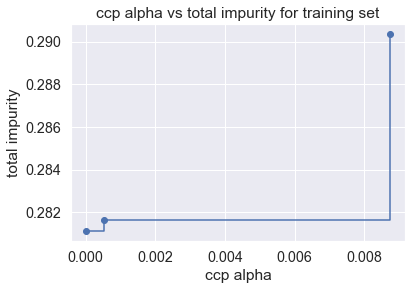

In [33]:
path = pruned_dt_clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print(ccp_alphas, impurities)

fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("ccp alpha")
ax.set_ylabel("total impurity")
ax.set_title("ccp alpha vs total impurity for training set")

In [34]:
import pandas as pd
import matplotlib.pyplot as plt   # package for plotting
from sklearn.tree import DecisionTreeClassifier, plot_tree
plt.rcParams['axes.unicode_minus'] = False       # 마이너스 부호 깨짐 현상 

In [35]:
data = pd.read_csv("default of credit card clients.csv", index_col=[0])
features = data.columns
print(features)

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')


In [36]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# 의사결정나무 모델 객체 생성
tree = DecisionTreeClassifier()

# 하이퍼파라미터 그리드 설정
param_grid = {'max_depth': range(1, 11), 'min_samples_split': range(2, 11)}

# GridSearchCV를 사용하여 가지치기 조정
grid = GridSearchCV(tree, param_grid = param_grid, cv = 5)
grid.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 검증 데이터에서의 최고 정확도 출력
print("Best parameter: ", grid.best_params_)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))


Best parameter:  {'max_depth': 4, 'min_samples_split': 2}
Best cross-validation score: 0.82


- max_depth와 min_samples_split이라는 두 개의 하이퍼파라미터를 그리드로 설정
- 5-fold 교차 검증(cross-validation)을 수행하여 최적의 하이퍼파라미터와 검증 데이터에서의 최고 정확도를 출력
- 이를 통해 가지치기의 정도를 결정 가능 => max-depth = 4, min_samples_split = 2, best cv score = 0.82

## 최적의 하이퍼파라미터로 가지치기 재수행

In [39]:
from sklearn import tree

# Initialize a decision tree estimator
tr1 = tree.DecisionTreeClassifier(max_depth = 4, criterion = 'gini', random_state = 25)

# Train the estimator
tr1.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=25)

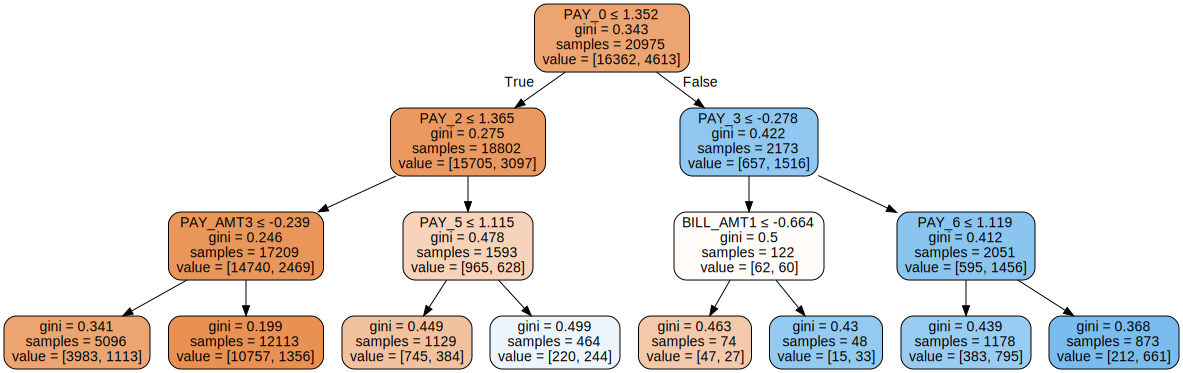

In [40]:
# Plot the tree.
dot_data = tree.export_graphviz(tr, out_file = None, feature_names = X.columns, 
                                filled = True, rounded = True, special_characters = True)  
graph = graphviz.Source(dot_data)  
graph

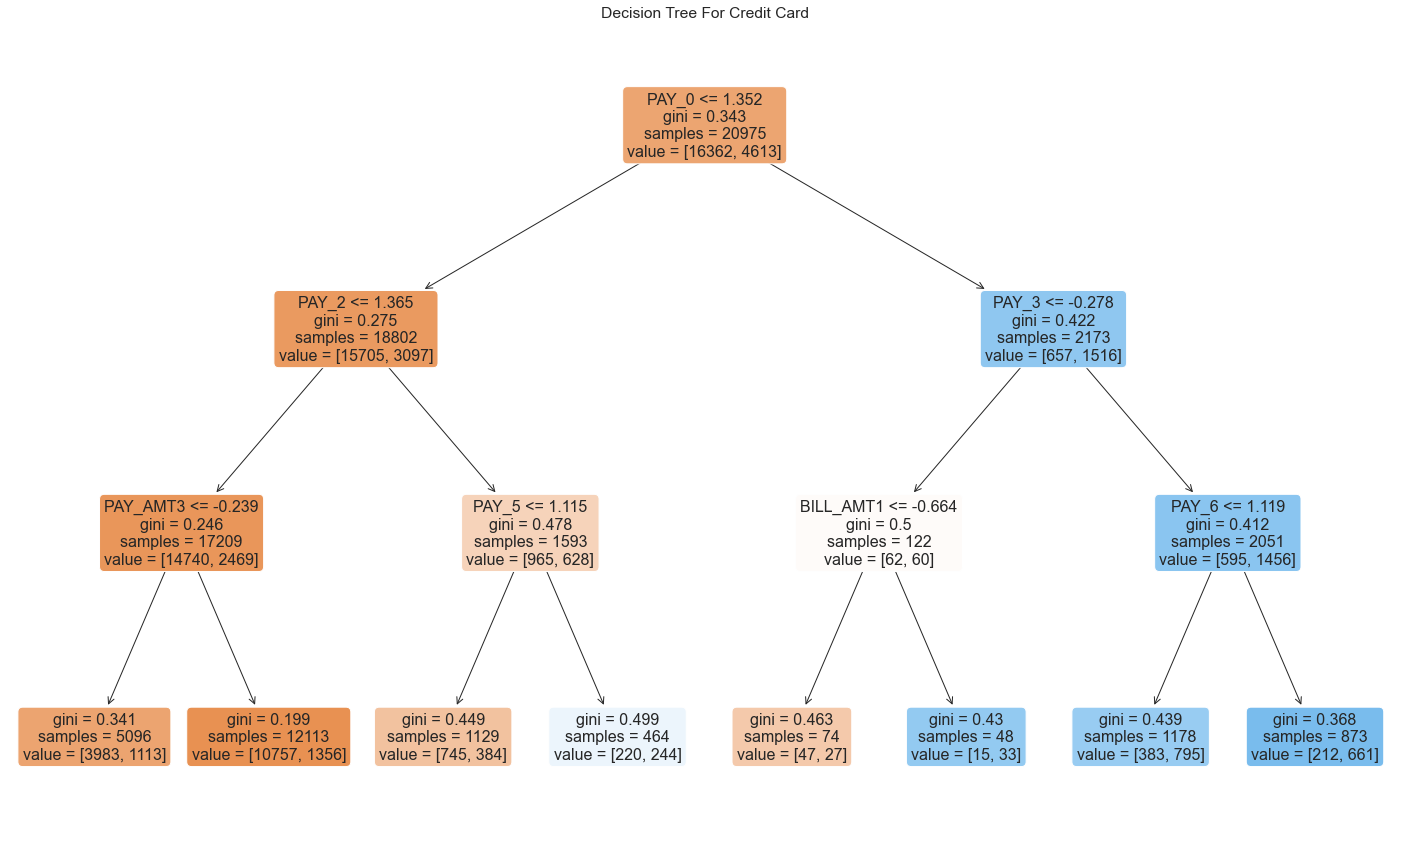

In [41]:
# Plot the tree
fig = plt.figure(figsize = (25, 15))
tree.plot_tree(tr.fit(X_train, y_train), feature_names = X.columns, filled = True, rounded = True, fontsize = 16);
plt.title('Decision Tree For Credit Card');

In [42]:
# simplified version
r = export_text(tr1, feature_names = X.columns.tolist())
print(r)

|--- PAY_0 <= 1.35
|   |--- PAY_2 <= 1.36
|   |   |--- PAY_AMT3 <= -0.24
|   |   |   |--- BILL_AMT1 <= -0.69
|   |   |   |   |--- class: 0
|   |   |   |--- BILL_AMT1 >  -0.69
|   |   |   |   |--- class: 0
|   |   |--- PAY_AMT3 >  -0.24
|   |   |   |--- PAY_4 <= 0.62
|   |   |   |   |--- class: 0
|   |   |   |--- PAY_4 >  0.62
|   |   |   |   |--- class: 0
|   |--- PAY_2 >  1.36
|   |   |--- PAY_5 <= 1.11
|   |   |   |--- LIMIT_BAL <= 0.13
|   |   |   |   |--- class: 0
|   |   |   |--- LIMIT_BAL >  0.13
|   |   |   |   |--- class: 0
|   |   |--- PAY_5 >  1.11
|   |   |   |--- PAY_AMT5 <= -0.31
|   |   |   |   |--- class: 1
|   |   |   |--- PAY_AMT5 >  -0.31
|   |   |   |   |--- class: 0
|--- PAY_0 >  1.35
|   |--- PAY_3 <= -0.28
|   |   |--- BILL_AMT1 <= -0.66
|   |   |   |--- BILL_AMT2 <= -0.68
|   |   |   |   |--- class: 0
|   |   |   |--- BILL_AMT2 >  -0.68
|   |   |   |   |--- class: 0
|   |   |--- BILL_AMT1 >  -0.66
|   |   |   |--- PAY_AMT5 <= 0.17
|   |   |   |   |--- class: 1
| 

- 앞에서 구한 최적의 파라미터로 의사결정나무 모델 구축을 확인한 결과, 전과 다른 것을 확인할 수 있다.
- 가지치기를 통해 의사결정나무 모델의 정확도가 향상하는 것을 알 수 있다.